In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
% matplotlib inline

# libraries for geo transformation to save file to shp format
import shapely.wkt
import geopandas as gpd

C:\Users\Michal_schudnij\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In this part of the study, we conduct non spatial exploratory data analysis. First, we compute descriptive stats. Then we check which variables should be removed from the dataset. For the remaining variables, we check their distributions with histograms and box plots. Next we calculate the correlation between the variables according to their category, i.e. operators, demographic and points of interest data. Finally, we transform variables if necessary - logarithmization and binarization of variables.

### Loading data

In [2]:
df_warszawa = pd.read_csv("../datasets/preprocessed_data/df_warszawa.csv")
df_krakow = pd.read_csv("../datasets/preprocessed_data/df_krakow.csv")
df_warszawa['city'] = 'Warszawa'
df_krakow['city'] = 'Krakow'

In [3]:
df = pd.concat([df_warszawa, df_krakow])
df = df.reset_index()
df = df.drop(columns = {'index'})
features = df.columns.to_list()
features.remove('grid_index')
features.remove('city')
features.remove('geometry')

In [4]:
df.head()

,grid_index,geometry,dhl,dpd,fedex,inpost,poczta,ruch,ups,tot,...,shops,parks,forests,schools,railways,cycleways,parkings,crossings,bus_stops,city
0,206436,"POLYGON ((20.85176726655831 52.18687052666358,...",0.0,0.0,0.0,0.0,1.0,0.0,1.0,4841,...,0.0,1.0,2.0,4.0,2.0,8.0,11.0,19.0,0.0,Warszawa
1,206464,"POLYGON ((20.87799146666601 52.29332742783289,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,137,...,0.0,0.0,7.0,1.0,0.0,0.0,1.0,1.0,0.0,Warszawa
2,206476,"POLYGON ((20.85394674013865 52.19574229917577,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,269,...,0.0,0.0,0.0,0.0,8.0,0.0,2.0,4.0,0.0,Warszawa
3,206492,"POLYGON ((20.88018378103267 52.3021984073102, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,Warszawa
4,206505,"POLYGON ((20.87580022757719 52.28445638326996,...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,386,...,0.0,0.0,8.0,0.0,0.0,4.0,3.0,1.0,0.0,Warszawa


### Descriptive statistics

Considering the descriptive stats table, we can see that we have a division into count data (operators and points of interest data) and a continuous variable (demographic data). In the next steps, we will examine the distributions of these variables and make some transformations.

In [5]:
df[features].describe()

,dhl,dpd,fedex,inpost,poczta,ruch,ups,tot,tot_0_14,tot_15_64,...,buildings,shops,parks,forests,schools,railways,cycleways,parkings,crossings,bus_stops
count,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,...,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000
mean,1.415246,0.384152,0.031093,1.385155,1.611836,0.352056,0.204614,2543.210632,334.043129,1784.209629,...,17.356068,0.270812,1.113340,10.199599,2.989970,8.476429,8.178536,14.986961,27.742227,0.544634
std,2.790922,0.846603,0.190213,2.112808,3.041015,0.845154,0.558126,4119.705771,502.378489,2884.319749,...,52.903305,1.022282,3.576782,10.469754,4.744676,19.672180,14.010474,24.877427,40.056972,1.958727
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,138.000000,22.000000,98.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,551.000000,93.000000,396.000000,...,1.000000,0.000000,0.000000,7.000000,1.000000,0.000000,1.000000,3.000000,8.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2746.000000,450.000000,1934.000000,...,11.000000,0.000000,1.000000,14.000000,4.000000,6.000000,11.000000,20.000000,41.000000,0.000000
max,28.000000,9.000000,2.000000,13.000000,23.000000,7.000000,5.000000,21531.000000,2672.000000,15020.000000,...,761.000000,15.000000,62.000000,68.000000,30.000000,133.000000,123.000000,203.000000,248.000000,15.000000


### Features to remove

The cell below shows what percentage of zero values each variable has in our dataset. If the ratio of zeroes for some variable is higher than 90%, such a variable is removed from our dataset.

In [6]:
to_remove = []
for i in features:
    print("\n ############ \nFeature:", i)
    print(round(df[i].value_counts()[0]/df.shape[0]*100,2), f"% of grids with 0 {i}.")
    print(df[i].nunique(), "unique values.")
    
    if(round(df[i].value_counts()[0]/df.shape[0]*100,2)>90):
        to_remove.append(i)
        features.remove(i)


 ############ 
Feature: dhl
62.29 % of grids with 0 dhl.
18 unique values.

 ############ 
Feature: dpd
76.13 % of grids with 0 dpd.
8 unique values.

 ############ 
Feature: fedex
97.19 % of grids with 0 fedex.
3 unique values.

 ############ 
Feature: poczta
59.88 % of grids with 0 poczta.
21 unique values.

 ############ 
Feature: ruch
79.74 % of grids with 0 ruch.
8 unique values.

 ############ 
Feature: ups
84.55 % of grids with 0 ups.
6 unique values.

 ############ 
Feature: tot
6.42 % of grids with 0 tot.
761 unique values.

 ############ 
Feature: tot_0_14
9.43 % of grids with 0 tot_0_14.
476 unique values.

 ############ 
Feature: tot_15_64
6.52 % of grids with 0 tot_15_64.
724 unique values.

 ############ 
Feature: tot_65__
9.43 % of grids with 0 tot_65__.
442 unique values.

 ############ 
Feature: tot_male
6.92 % of grids with 0 tot_male.
655 unique values.

 ############ 
Feature: tot_fem
7.22 % of grids with 0 tot_fem.
657 unique values.

 ############ 
Feature: male_

In [7]:
# Variables to_remove
to_remove

['fedex']

In [8]:
# dropping columns
df = df.drop(columns = to_remove)

### Histograms and boxplots for each variable

Using histgrams and a plot box, we examine the distributions of all variables. As expected, most features have similar distributions - very many low values and a very long tail with high values.

##############
dhl
##############


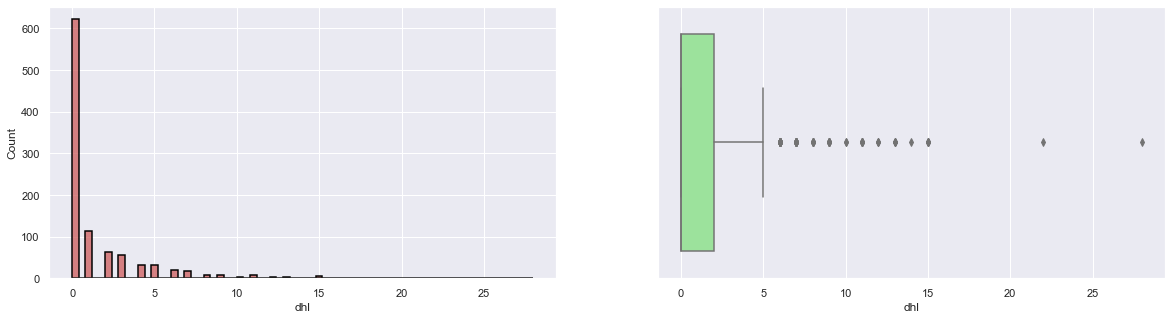

##############
dpd
##############


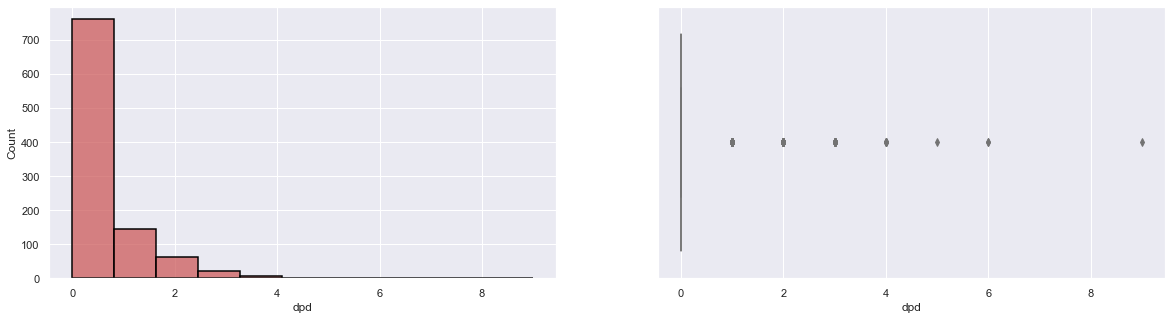

##############
inpost
##############


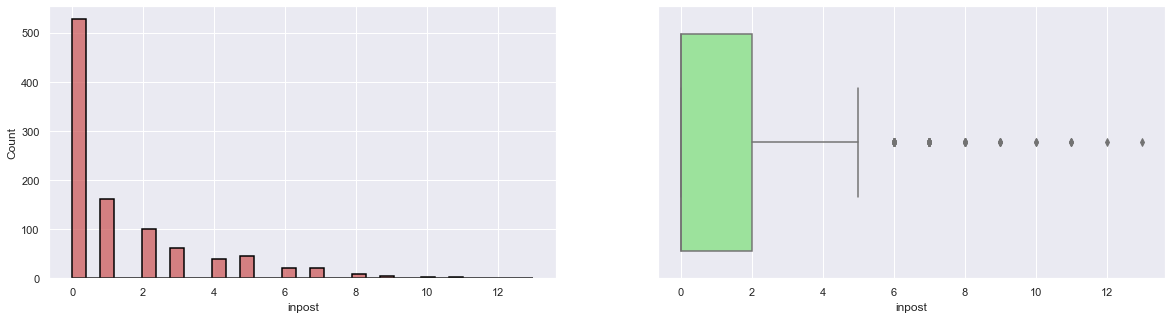

##############
poczta
##############


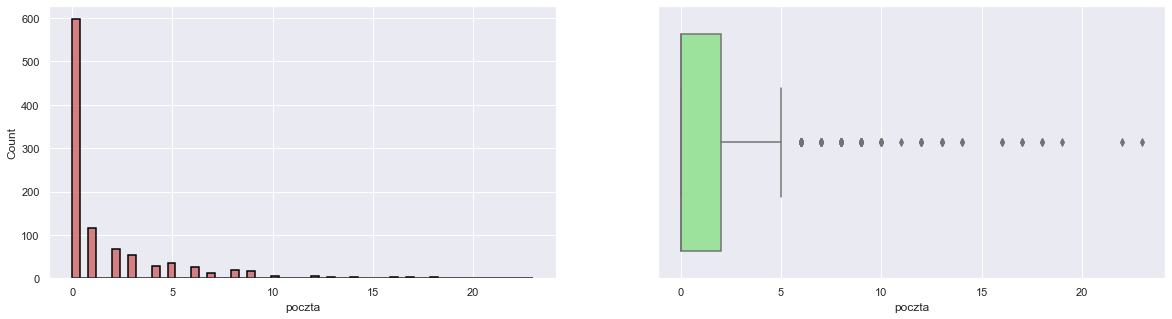

##############
ruch
##############


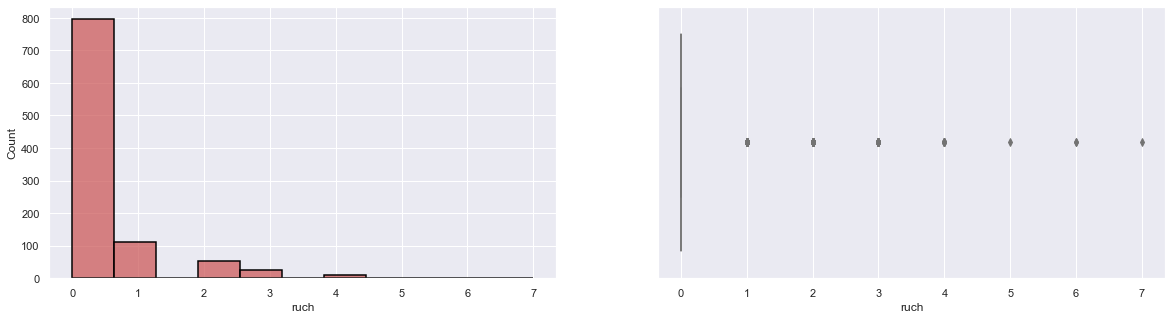

##############
ups
##############


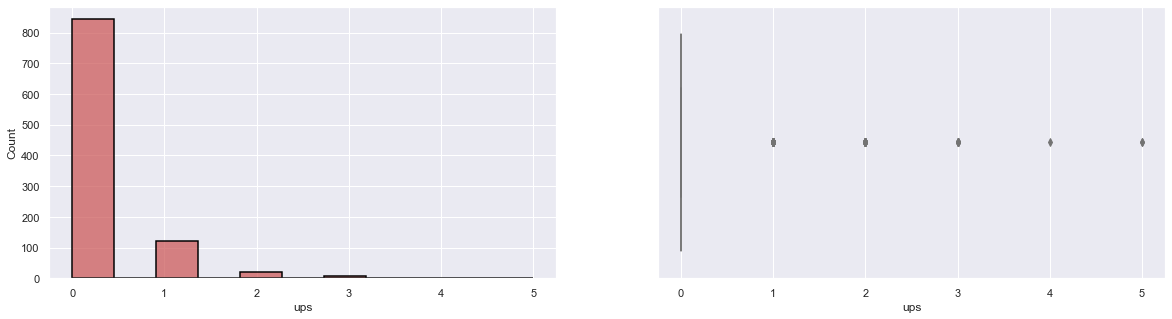

##############
tot
##############


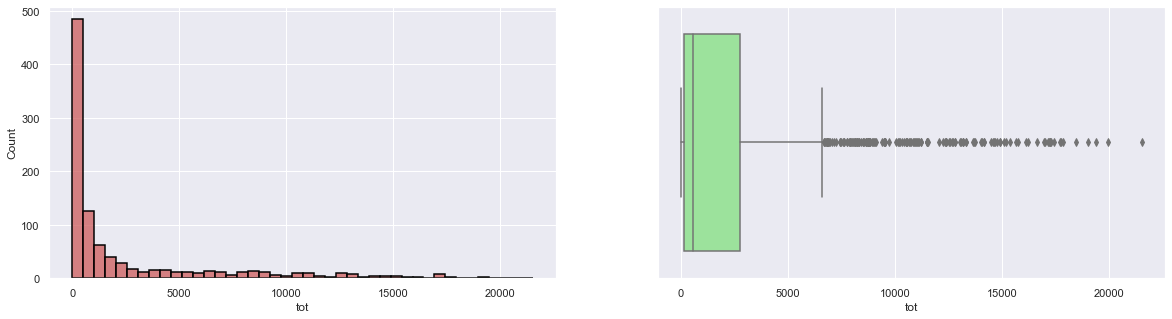

##############
tot_0_14
##############


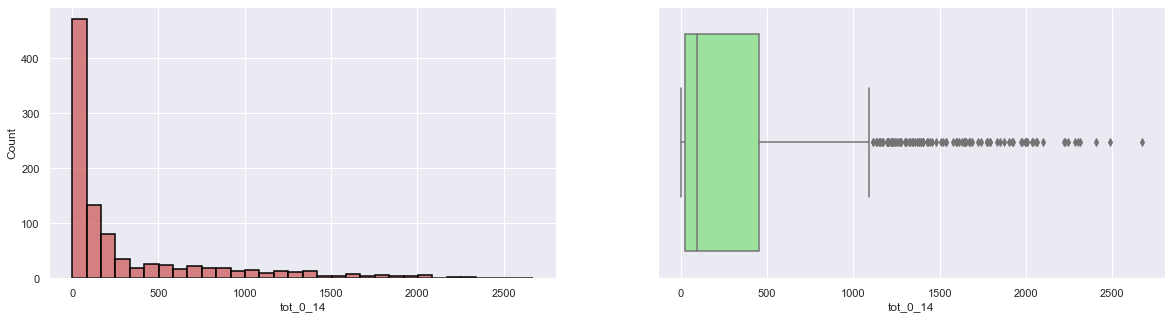

##############
tot_15_64
##############


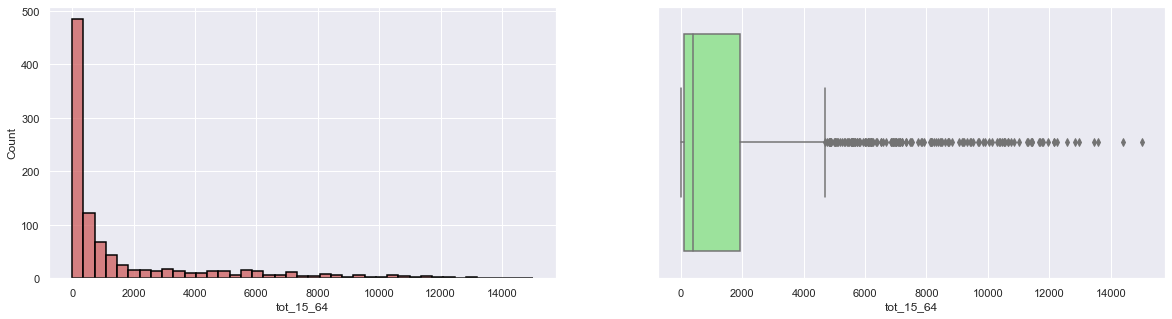

##############
tot_65__
##############


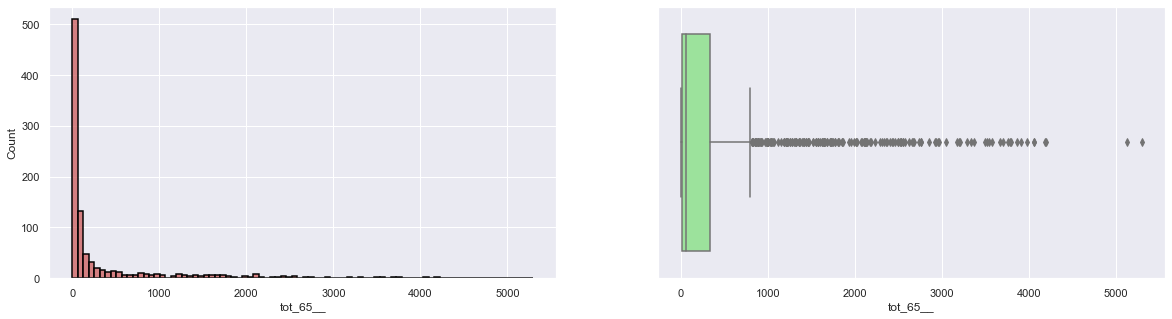

##############
tot_male
##############


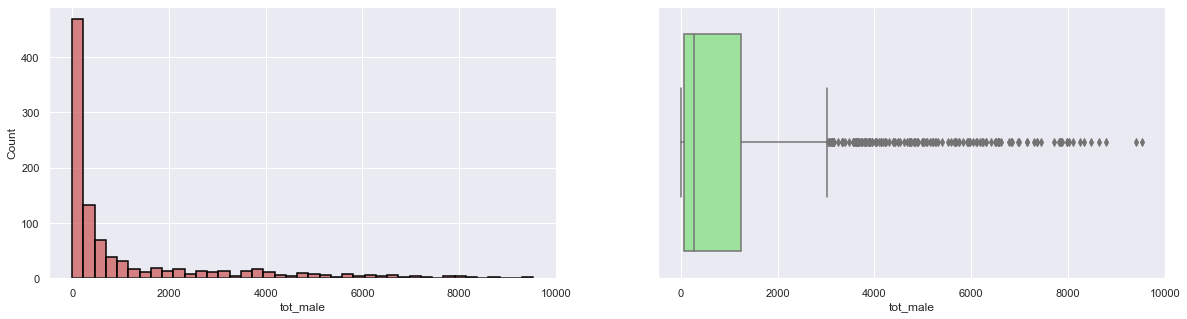

##############
tot_fem
##############


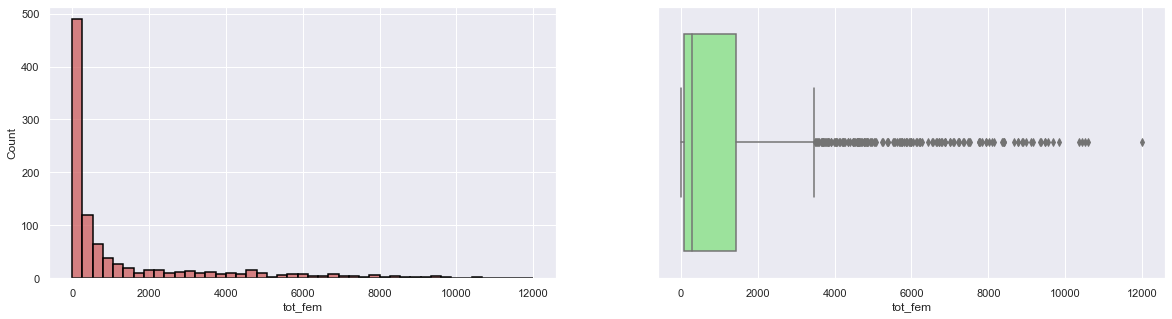

##############
male_0_14
##############


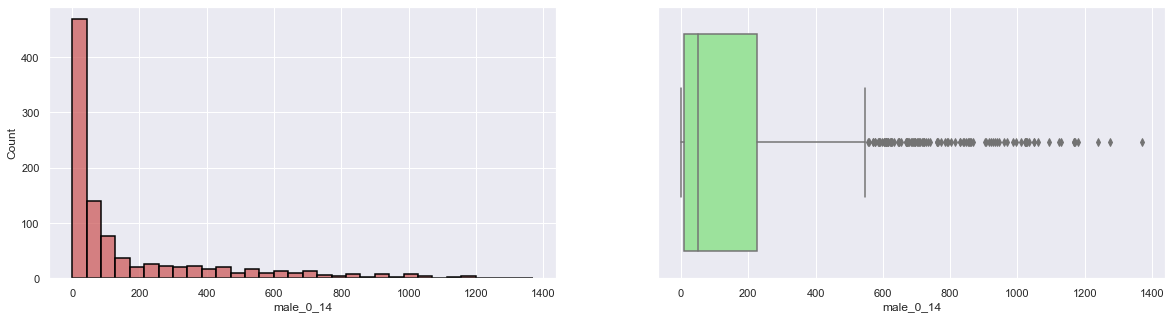

##############
male_15_64
##############


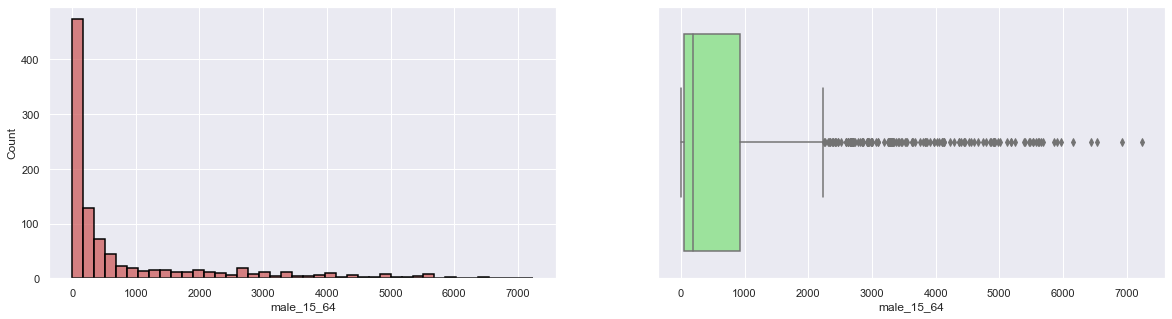

##############
male_65__
##############


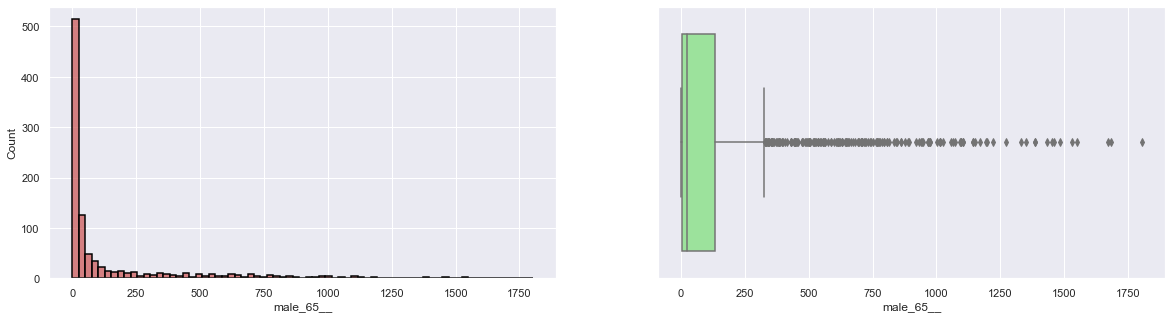

##############
fem_0_14
##############


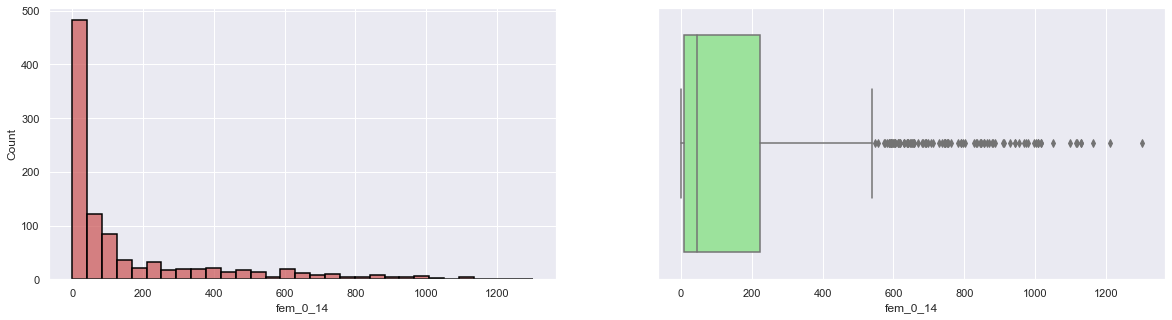

##############
fem_15_64
##############


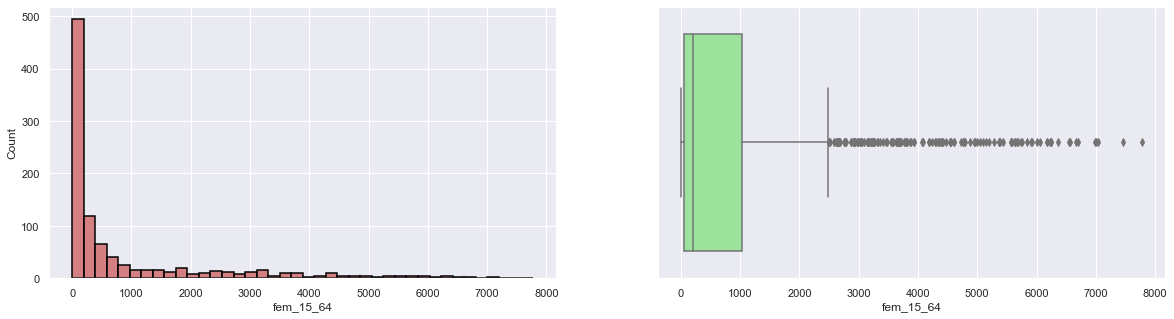

##############
fem_65__
##############


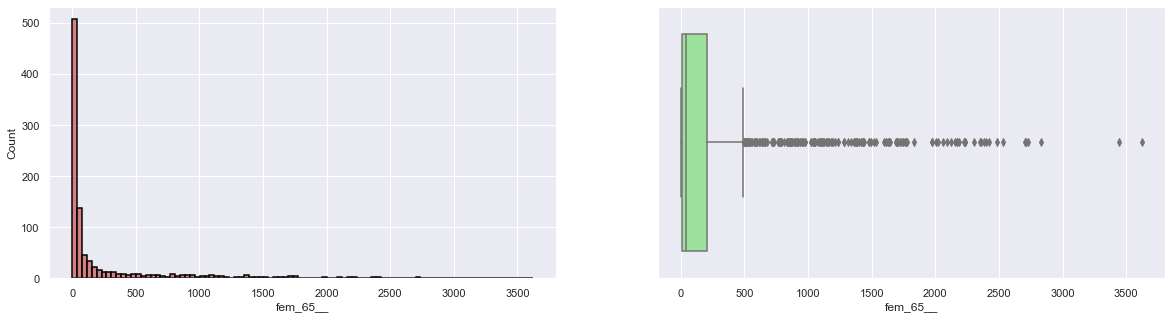

##############
fem_ratio
##############


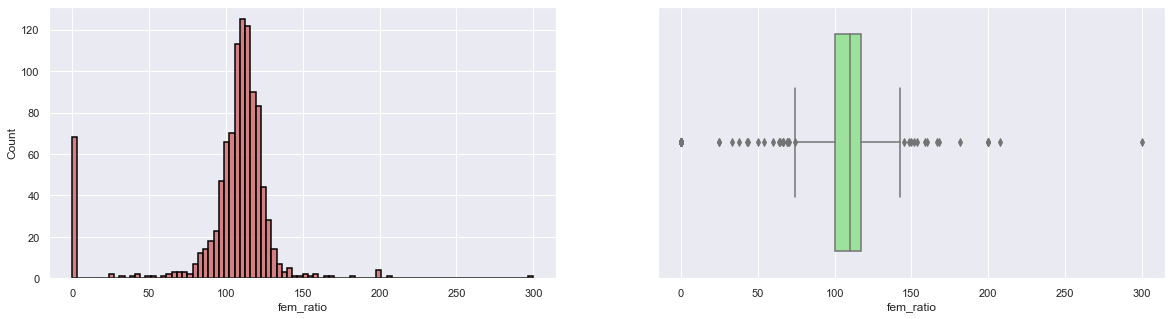

##############
buildings
##############


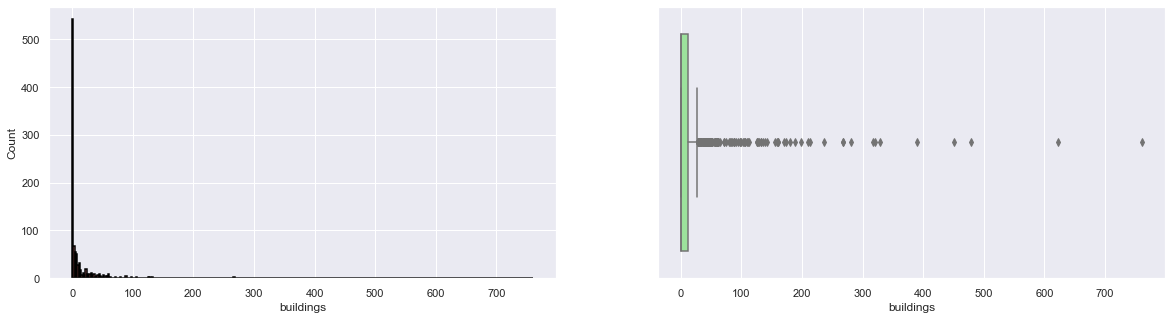

##############
shops
##############


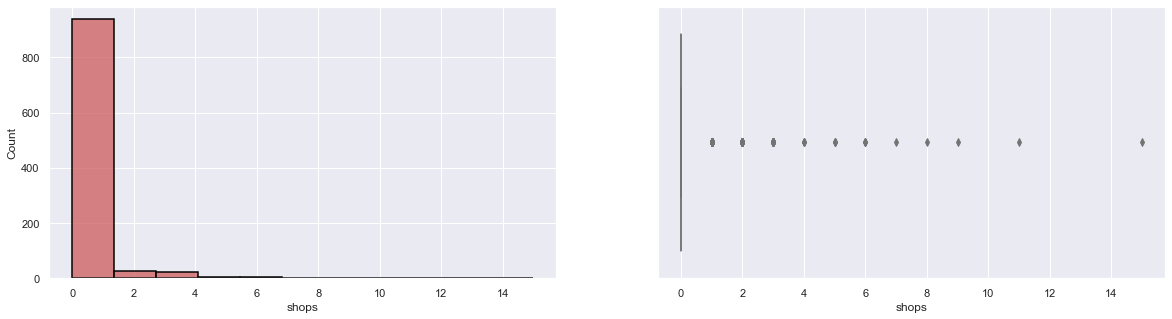

##############
parks
##############


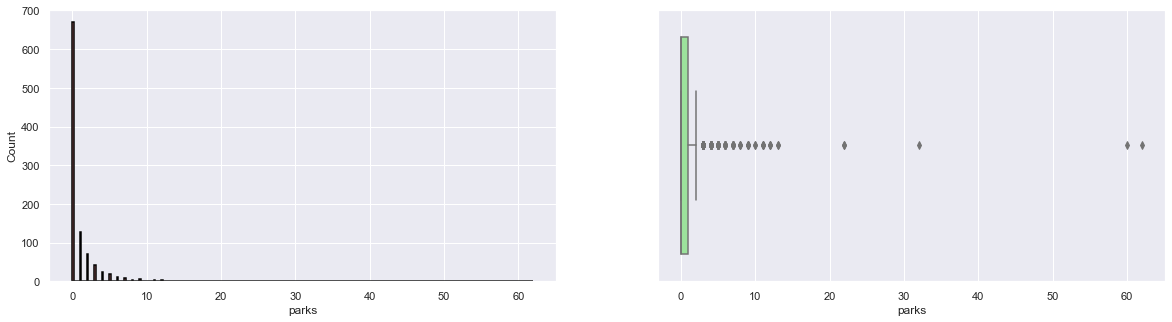

##############
forests
##############


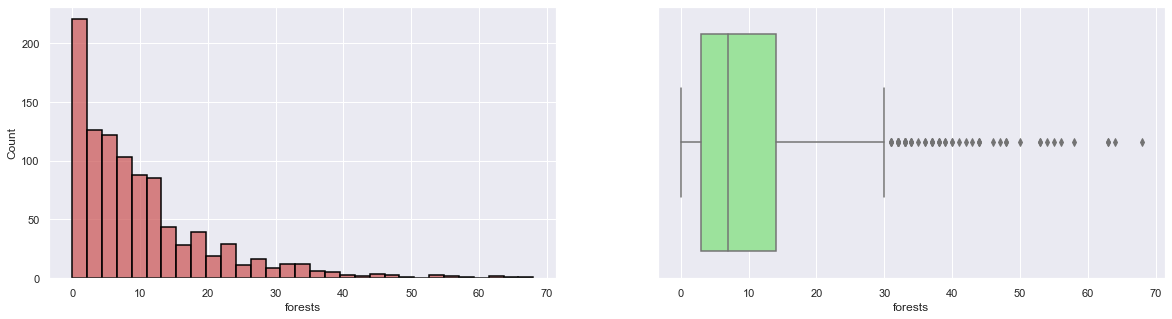

##############
schools
##############


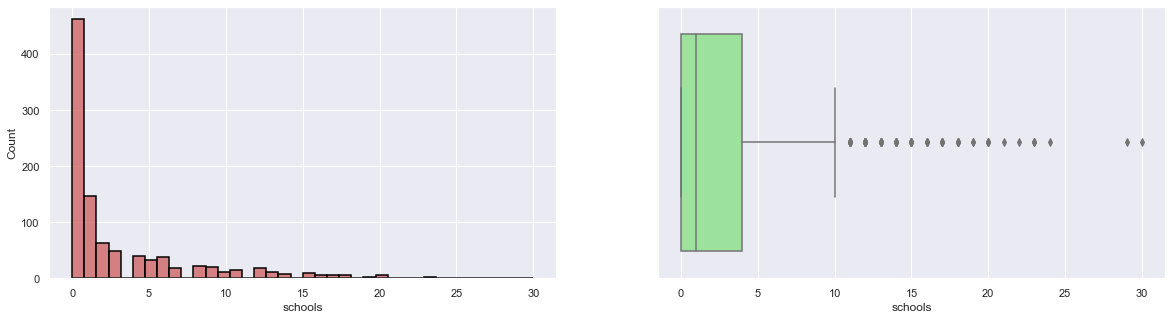

##############
railways
##############


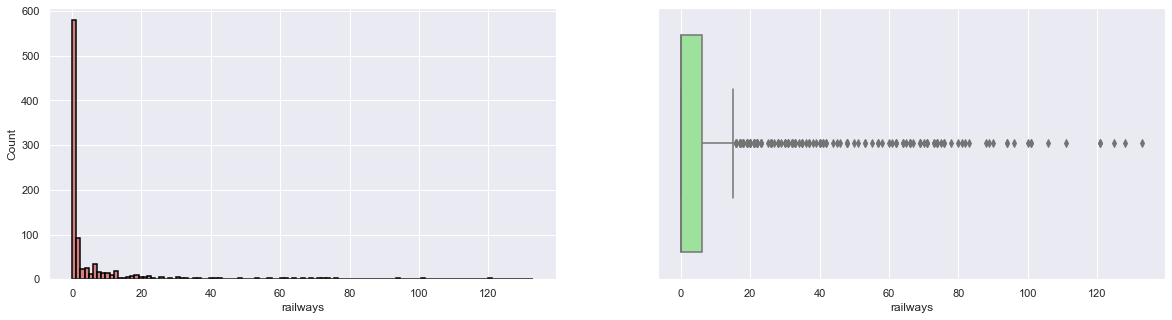

##############
cycleways
##############


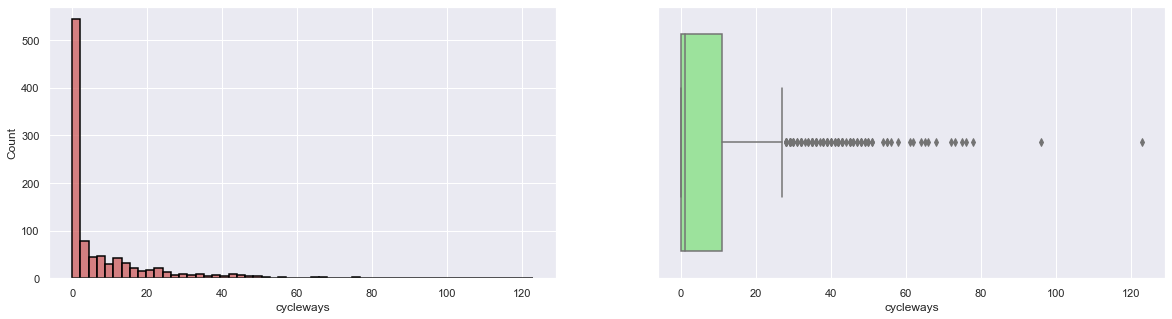

##############
parkings
##############


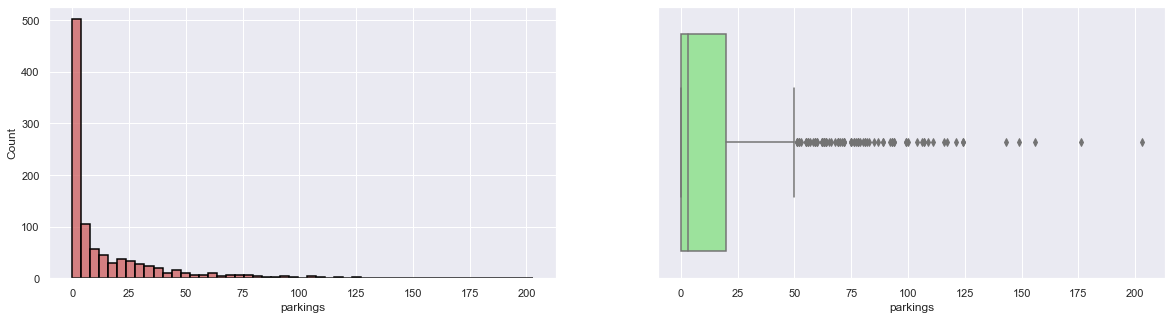

##############
crossings
##############


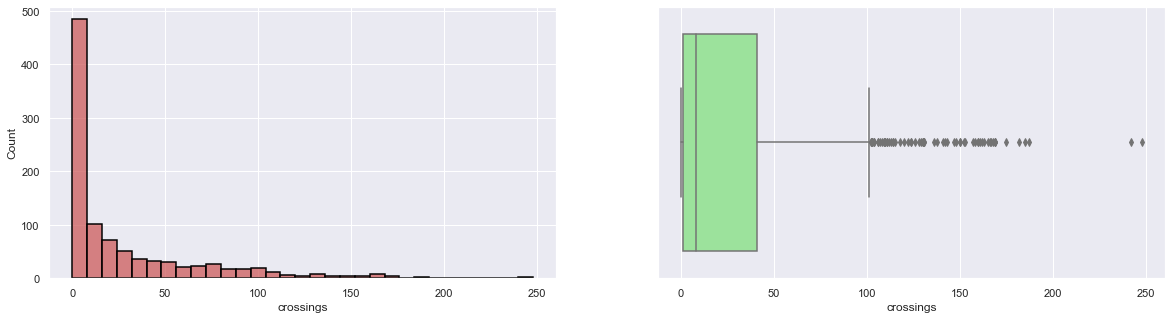

##############
bus_stops
##############


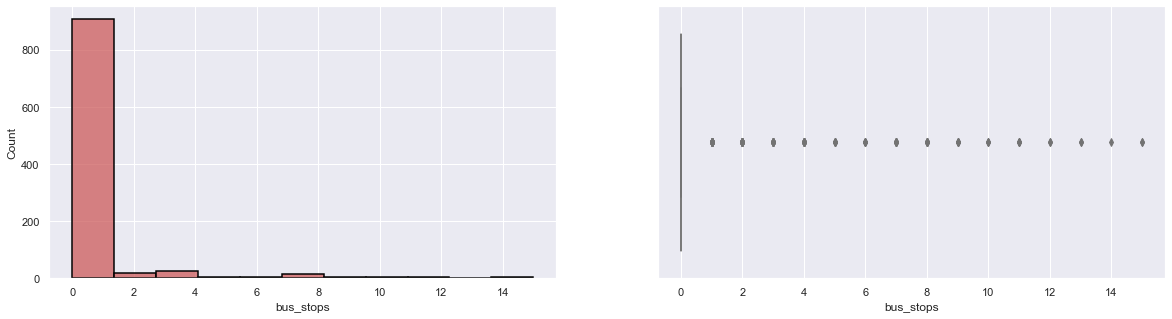

In [9]:
plt.rcParams["figure.figsize"] = (20, 5)

for i in features:
    print(f"##############\n{i}\n##############")
    
    fig, ax = plt.subplots(1,2)
    sns.histplot(x = df[i], kde=False, edgecolor= "black", color = 'indianred', linewidth= 1.5, ax=ax[0])
    sns.boxplot(x = df[i], color = 'lightgreen', ax=ax[1])
    plt.show()


### Correlation

Next, we examine the correlation of the variables. Due to the relatively large dataset, we will divide the correlation study into three smaller sets according to the characteristics of the variables.

In [10]:
df[features].corr()

,dhl,dpd,inpost,poczta,ruch,ups,tot,tot_0_14,tot_15_64,tot_65__,...,buildings,shops,parks,forests,schools,railways,cycleways,parkings,crossings,bus_stops
dhl,1.000000,0.633123,0.727989,0.932383,0.658593,0.555149,0.696275,0.659447,0.697047,0.643538,...,0.185447,0.479602,0.344888,-0.133477,0.604301,0.289551,0.540549,0.637894,0.772562,0.279078
dpd,0.633123,1.000000,0.577858,0.678825,0.588176,0.456063,0.619756,0.595723,0.620055,0.568814,...,0.176436,0.344869,0.324798,-0.116721,0.551852,0.153517,0.366910,0.531104,0.612811,0.170380
inpost,0.727989,0.577858,1.000000,0.726329,0.638070,0.538468,0.766055,0.761541,0.766040,0.688976,...,0.216337,0.379784,0.264850,-0.140325,0.690957,0.198831,0.526453,0.663942,0.707653,0.267564
poczta,0.932383,0.678825,0.726329,1.000000,0.750532,0.594024,0.771962,0.719797,0.768171,0.736826,...,0.228131,0.475660,0.380657,-0.153786,0.648610,0.273804,0.526729,0.653151,0.797082,0.322244
ruch,0.658593,0.588176,0.638070,0.750532,1.000000,0.553793,0.724067,0.656740,0.713889,0.725747,...,0.191366,0.410148,0.390661,-0.092028,0.600039,0.136766,0.366073,0.578649,0.674947,0.172145
ups,0.555149,0.456063,0.538468,0.594024,0.553793,1.000000,0.559764,0.518229,0.560632,0.523815,...,0.116203,0.275840,0.321317,-0.073834,0.472428,0.089415,0.353809,0.453653,0.524784,0.159706
tot,0.696275,0.619756,0.766055,0.771962,0.724067,0.559764,1.000000,0.957820,0.997314,0.931054,...,0.259645,0.462499,0.369480,-0.139503,0.839171,0.156490,0.527990,0.726357,0.765618,0.299617
tot_0_14,0.659447,0.595723,0.761541,0.719797,0.656740,0.518229,0.957820,1.000000,0.963425,0.812264,...,0.255449,0.407450,0.328193,-0.127525,0.835546,0.122008,0.491048,0.718564,0.720328,0.281477
tot_15_64,0.697047,0.620055,0.766040,0.768171,0.713889,0.560632,0.997314,0.963425,1.000000,0.904629,...,0.257876,0.463317,0.363946,-0.139253,0.839450,0.155397,0.523403,0.732276,0.760263,0.305834
tot_65__,0.643538,0.568814,0.688976,0.736826,0.725747,0.523815,0.931054,0.812264,0.904629,1.000000,...,0.241371,0.445171,0.375790,-0.133190,0.752883,0.165183,0.511762,0.634516,0.732433,0.257589


In [11]:
plt.rcParams["figure.figsize"] = (20, 16)

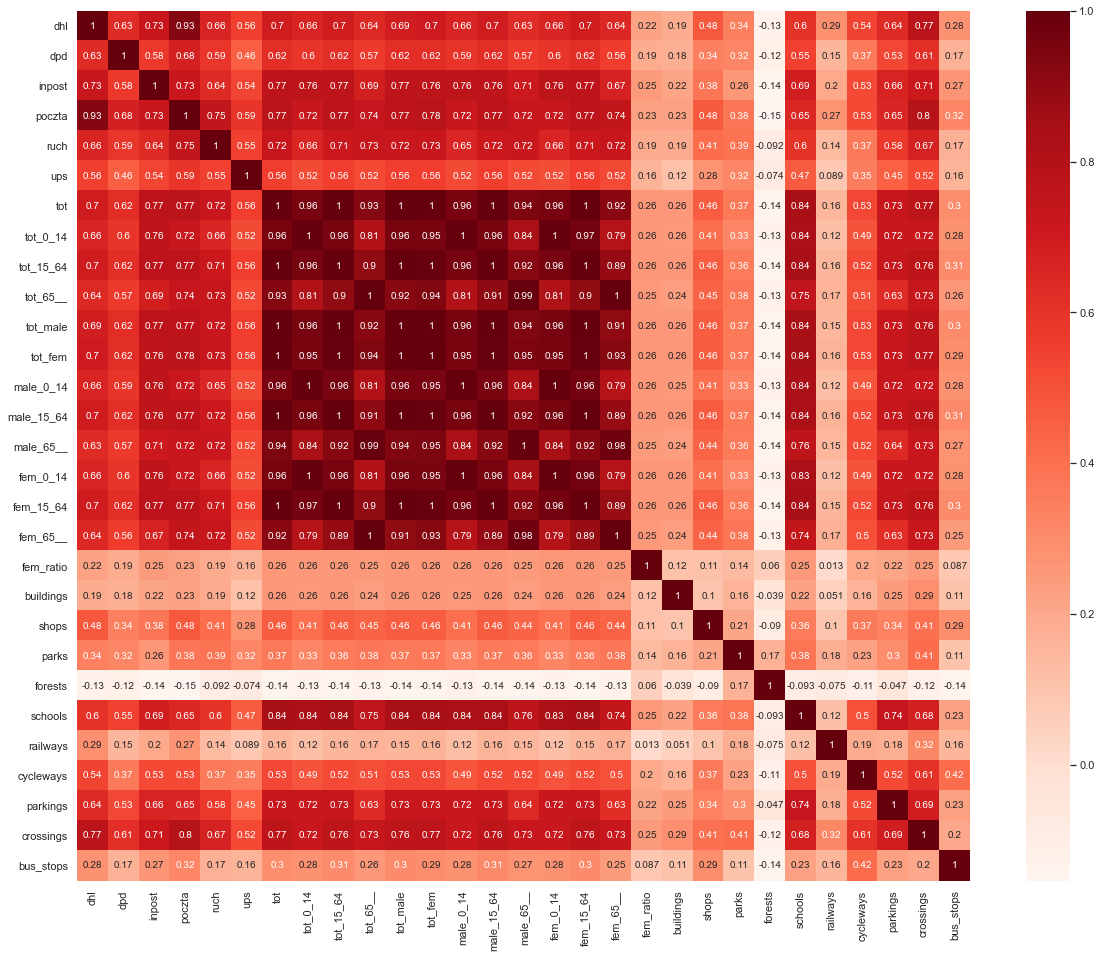

In [12]:
sns.heatmap(df[features].corr(), annot=True, cmap = 'Reds')
plt.show()

Division into three smaller sets

In [13]:
operators = ['dhl','dpd','inpost','poczta','ruch','ups']
demo = ['tot','tot_0_14','tot_15_64','tot_65__','tot_male','tot_fem','male_0_14','male_15_64','male_65__','fem_0_14','fem_15_64','fem_65__','fem_ratio']
points = ['buildings','shops','parks','forests','schools','railways','cycleways','parkings','crossings']

#### Correlation for operators variable

The correlation between DHL and Poczta Polska is disturbing - as much as 93%! In the next stages of the study, we will decide which variable should possibly be removed during modeling. It should also be noted the relatively high correlation between Poczta Polska and Ruch and between Inpost and DHL.

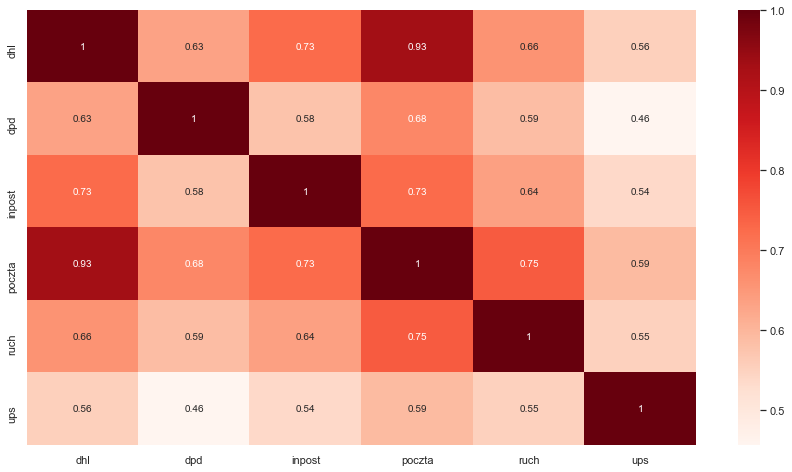

In [14]:
plt.rcParams["figure.figsize"] = (15, 8)
sns.heatmap(df[operators].corr(), annot=True, cmap = 'Reds')
plt.show()

The correlation between the demographic variables is extremely high. Only the variable that determines the "female ratio" is not correlated with the other variables. Most of these variables should be removed in the subsequent phases of the study.

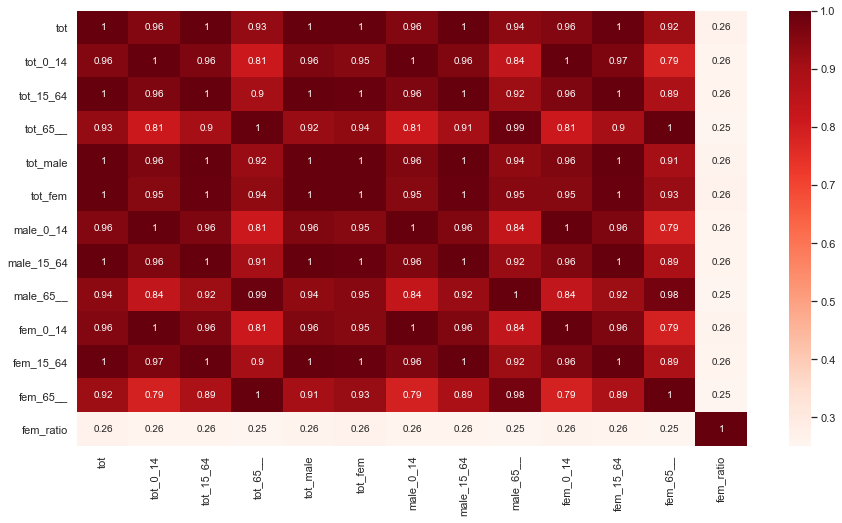

In [15]:
plt.rcParams["figure.figsize"] = (15, 8)
sns.heatmap(df[demo].corr(), annot=True, cmap = 'Reds')
plt.show()

The last correlation plot is for the points of interest variables. The highest correlation between the variables is for "parkings" and "schools" ~ 74%.

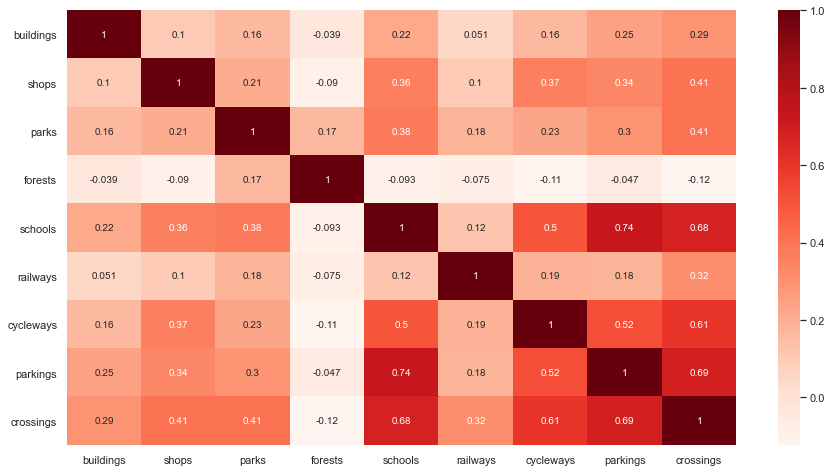

In [16]:
plt.rcParams["figure.figsize"] = (15, 8)
sns.heatmap(df[points].corr(), annot=True, cmap = 'Reds')
plt.show()

### Transformations of variables

The function below checks if a variable should be binarized (according to the rule, when the most common value for a variable is over 33% of all observations). If a variable is binarized, the new variable is visualized and the new variable is appended to the entire dataset.

In [17]:
def visualisation_binary(df, var):
    new_name = var + '_binary'
    if(df[var].value_counts().iloc[0] > int(df.shape[0]*0.33)):
        print('\nnew variable: "' + new_name + '"')
        pyk = df[var].value_counts().index[0]
        df[new_name] = df[var].apply(lambda x: 'few_'+var if x == 0  else 'more_'+var)
        plt.figure(figsize=(10, 5))
        df[new_name].value_counts().plot(kind='bar')
        plt.plot()
        plt.show()
    else: print(f'\nno binary transformation for variable "{var}"')


new variable: "buildings_binary"


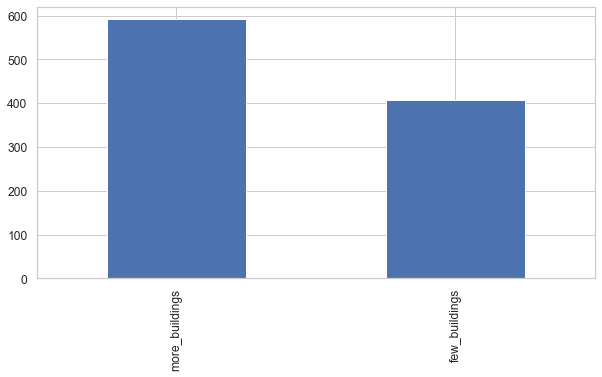


new variable: "shops_binary"


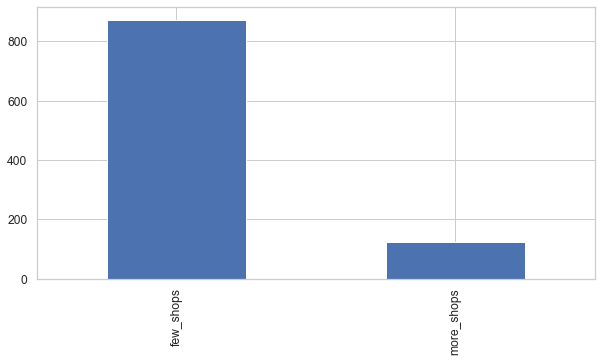


new variable: "parks_binary"


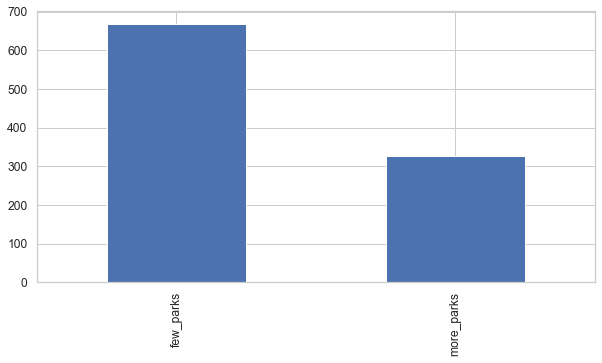


no binary transformation for variable "forests"

new variable: "schools_binary"


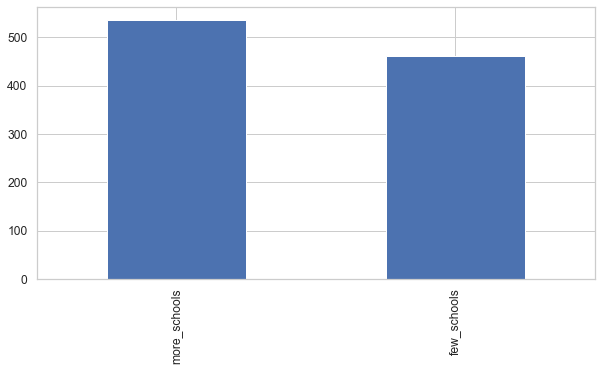


new variable: "railways_binary"


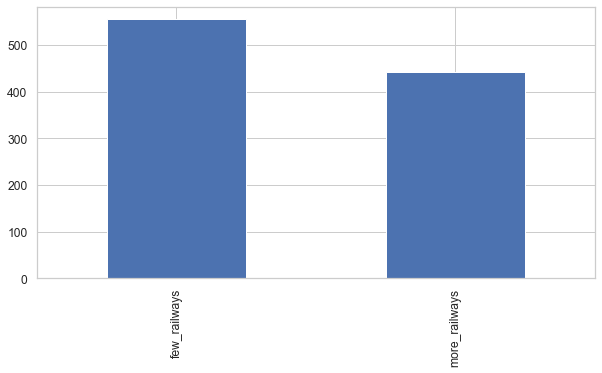


new variable: "cycleways_binary"


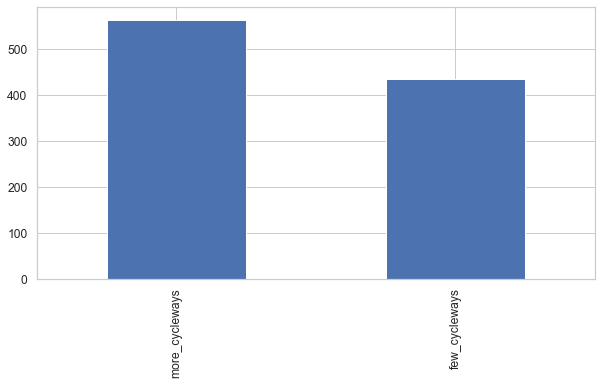


no binary transformation for variable "parkings"

no binary transformation for variable "crossings"


In [18]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 5]})
for point in points:
    visualisation_binary(df, point)

Then we log the variables for demographic features (due to the fact that they are continuous and their distributions have a long tail). The left-hand side shows the distributions before the transformation, while the right-hand side shows the variables after the transformation.

In [19]:
def visualisation_log(df, var):
    new_name = var + 'log'

    df[new_name] = np.log(1+df[var])

    fig, ax = plt.subplots(1,2)
    sns.histplot(x = df[var], kde=False, edgecolor= "black", color = 'indianred', linewidth= 1.5, ax=ax[0]).set_title(f"{var}", fontsize=20)
    sns.histplot(x = df[new_name], kde=False, edgecolor= "black", color = 'lightgreen', linewidth= 1.5, ax=ax[1]).set_title(f"Logarithm of {var}", fontsize=20)
    plt.plot()
    plt.show()

In [20]:
demo_logarithms = ['tot','tot_0_14','tot_15_64','tot_65__','tot_male','tot_fem','male_0_14','male_15_64','male_65__','fem_0_14','fem_15_64','fem_65__']

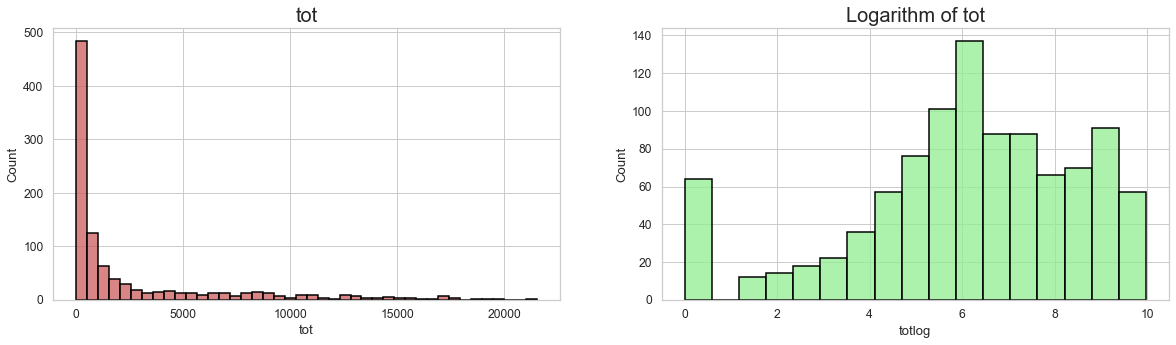

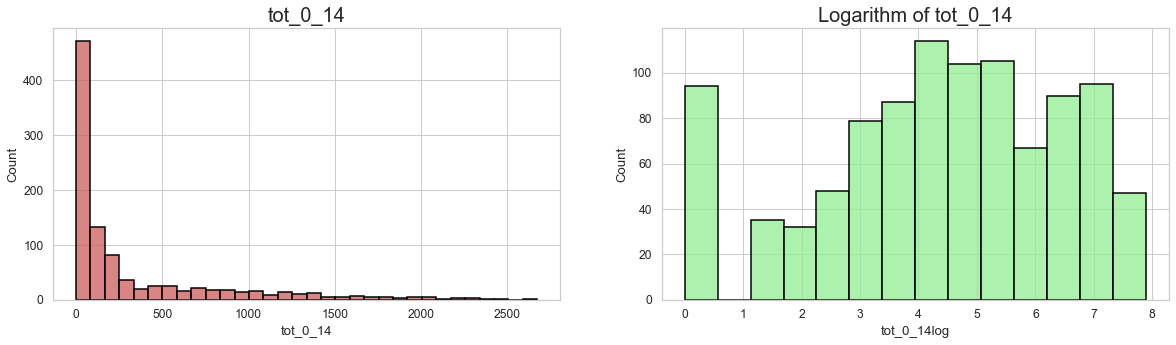

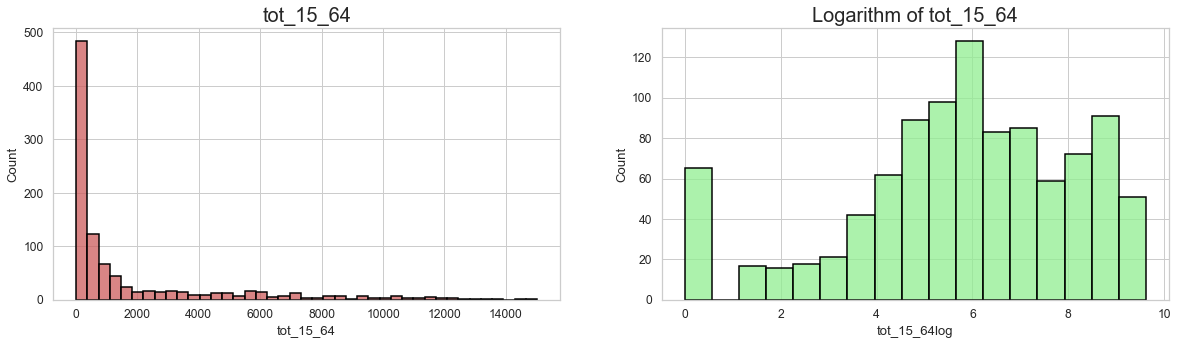

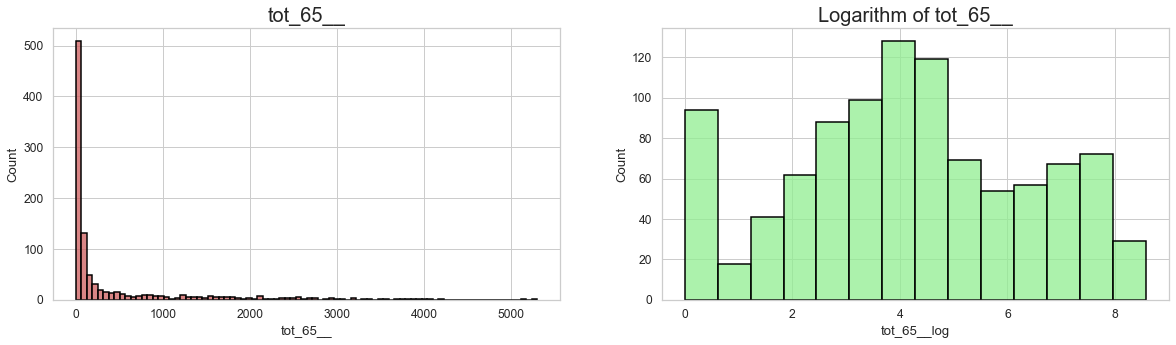

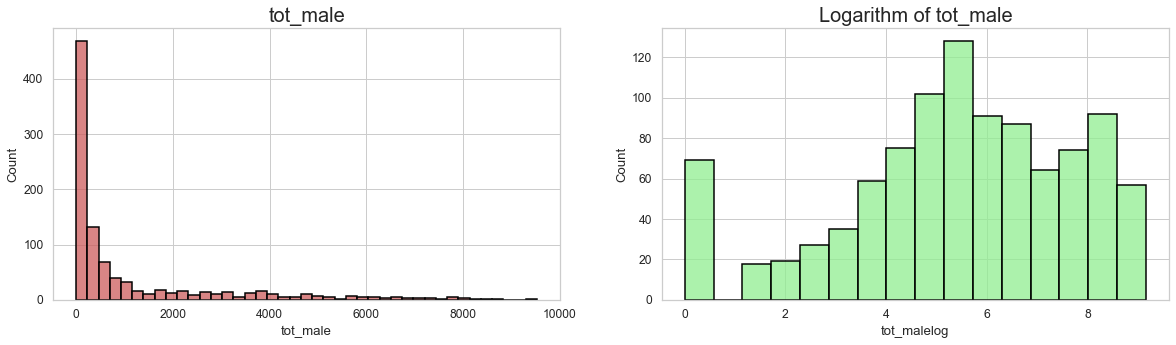

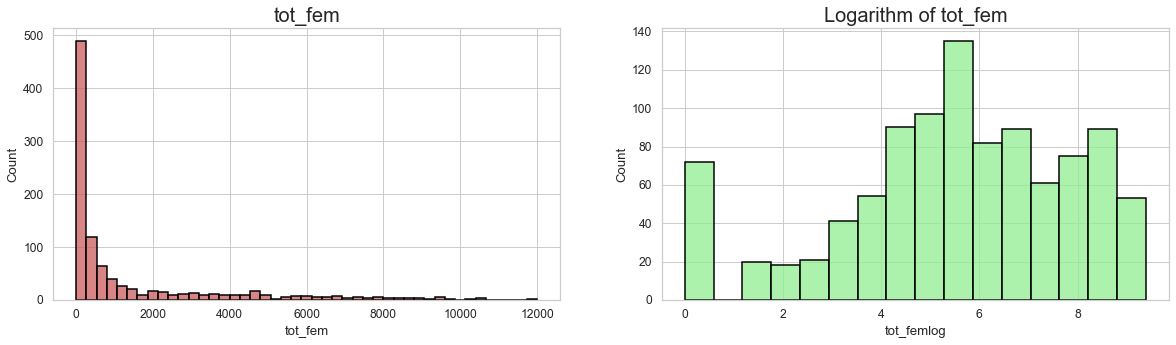

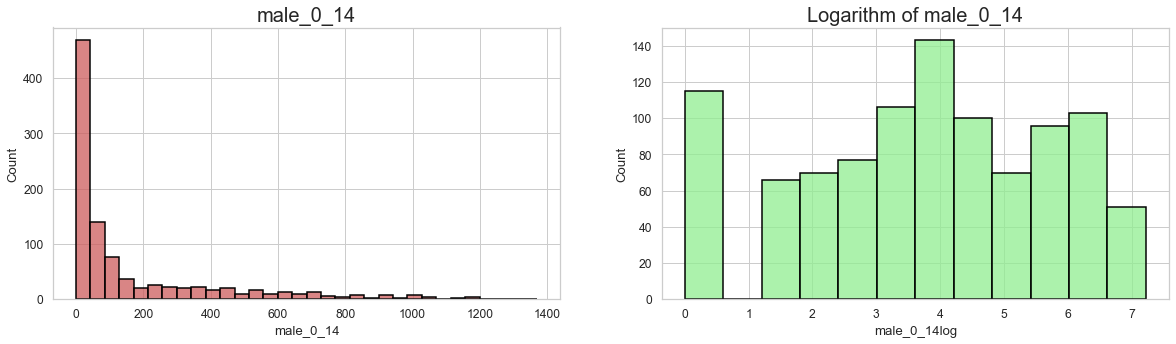

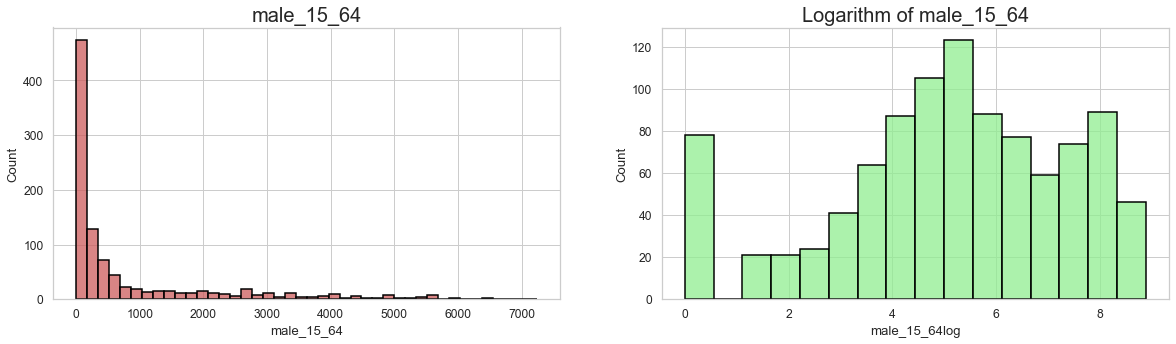

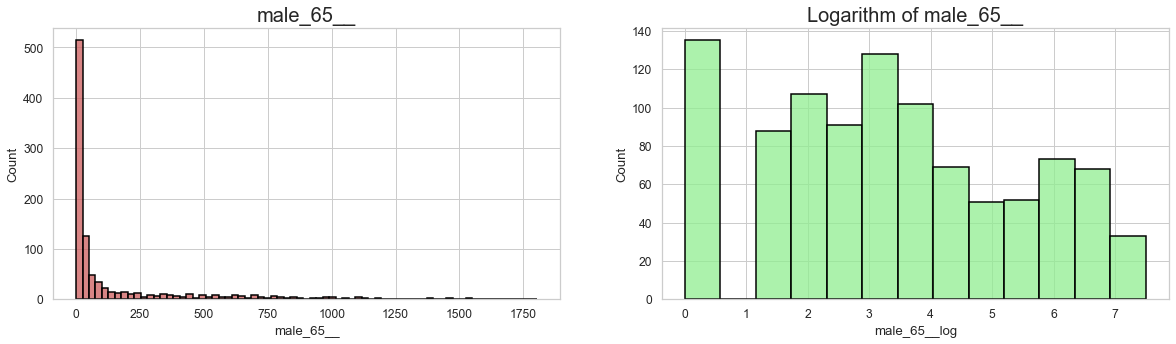

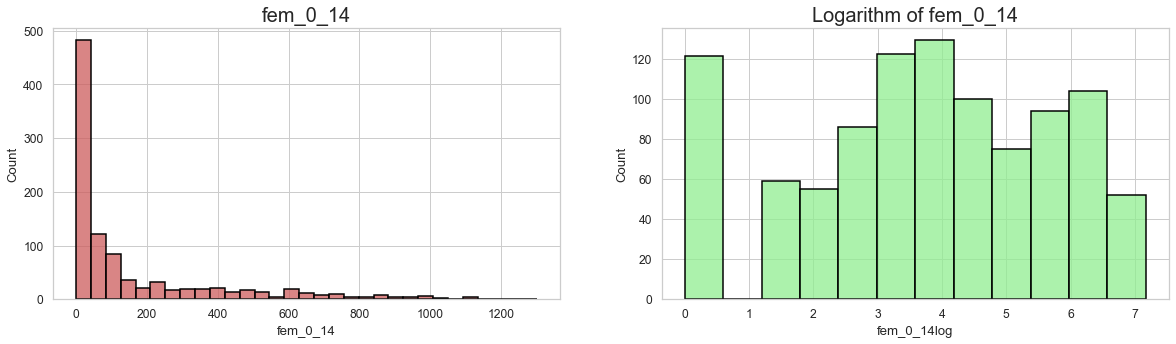

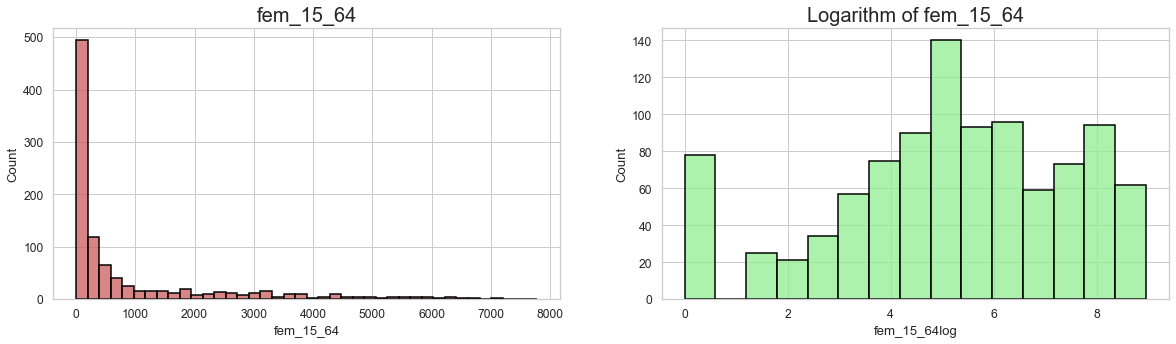

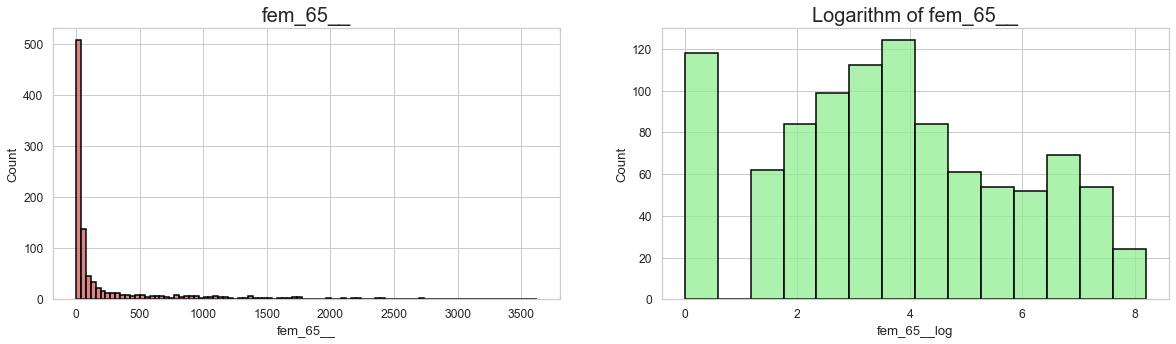

In [21]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 5]})
for point in demo_logarithms:
    visualisation_log(df, point)

In [23]:
# df.to_csv("../datasets/preprocessed_data/df_after_transform.csv", index=False)

### Transformations for GWR
Above transformation will also be applied for the GWR datasets.

In [22]:
df_warszawa = pd.read_csv("../datasets/preprocessed_data/df_warszawa_gwr.csv")
df_krakow = pd.read_csv("../datasets/preprocessed_data/df_krakow_gwr.csv")
df_warszawa['city'] = 'Warszawa'
df_krakow['city'] = 'Krakow'

df_gwr = pd.concat([df_warszawa, df_krakow])
df_gwr = df_gwr.reset_index()
df_gwr = df_gwr.drop(columns = {'index'})

In [23]:
demo_logarithms_gwr = ['TOT','TOT_0_14','TOT_15_64','TOT_65__','TOT_MALE','TOT_FEM','MALE_0_14','MALE_15_64','MALE_65__','FEM_0_14','FEM_15_64','FEM_65__']


no binary transformation for variable "buildings"

new variable: "shops_binary"


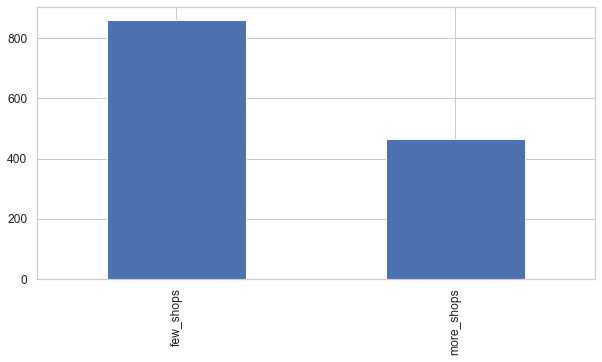


no binary transformation for variable "parks"

no binary transformation for variable "forests"

no binary transformation for variable "schools"

new variable: "railways_binary"


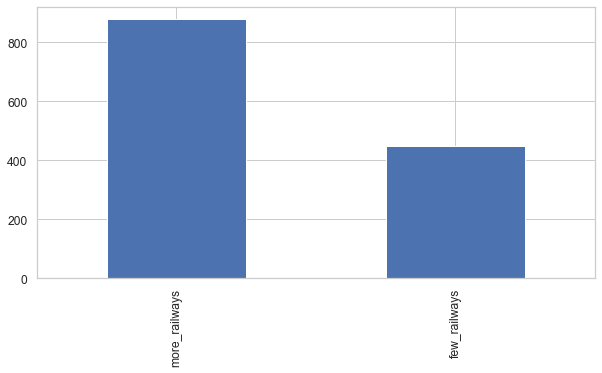


no binary transformation for variable "cycleways"

no binary transformation for variable "parkings"

no binary transformation for variable "crossings"


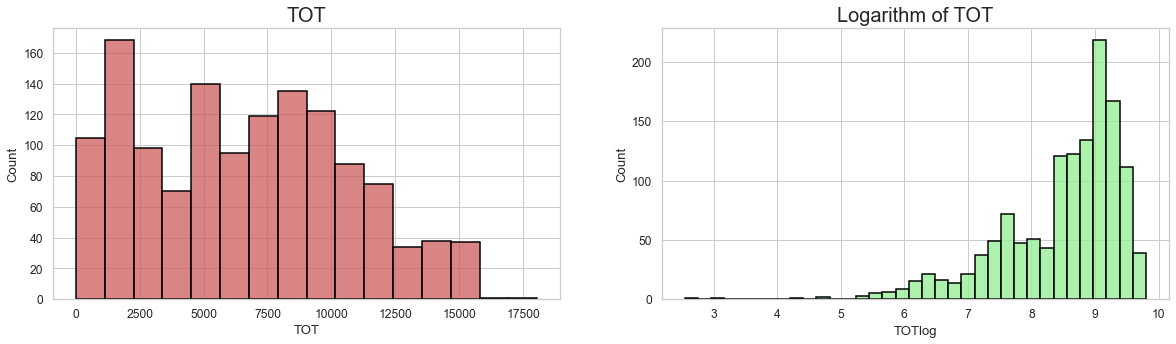

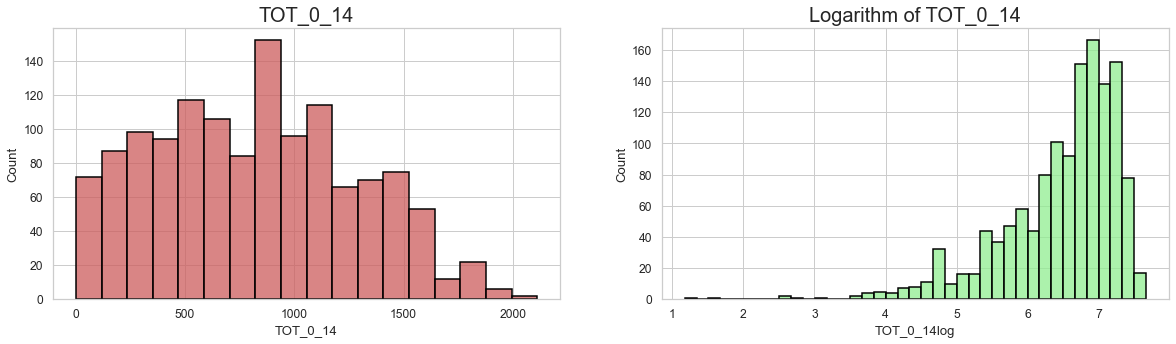

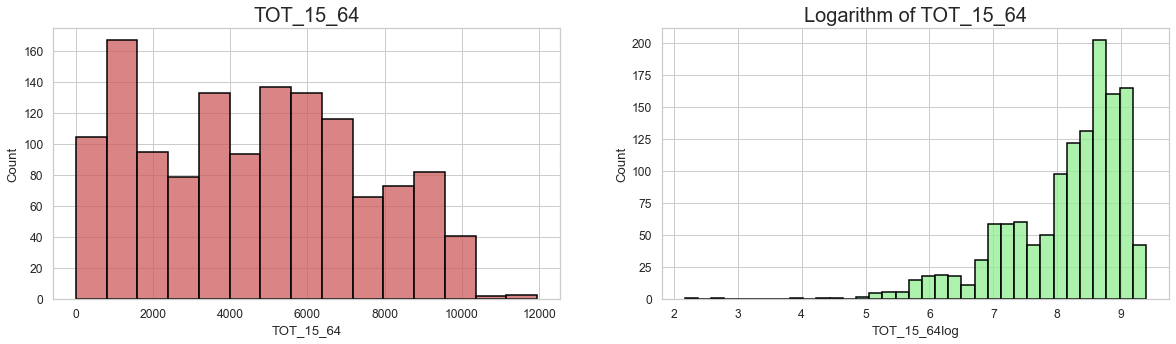

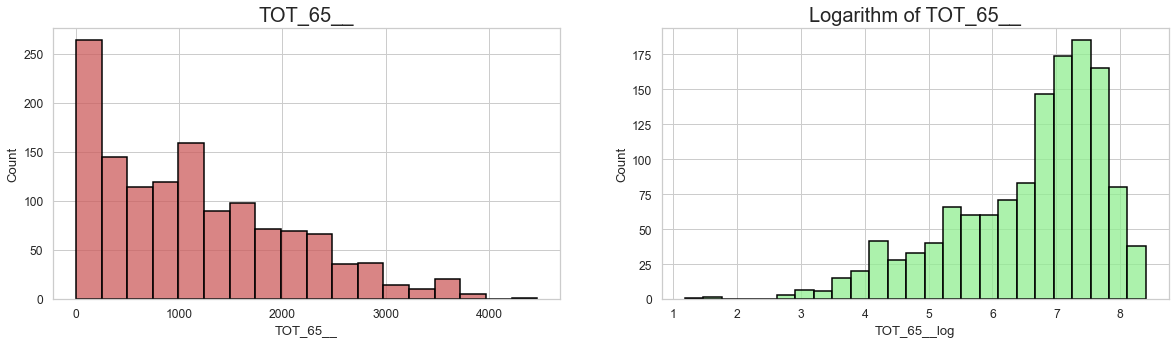

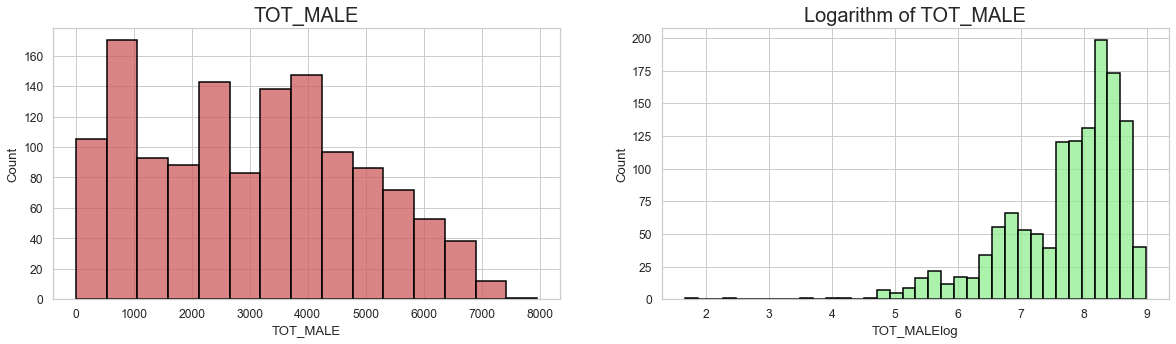

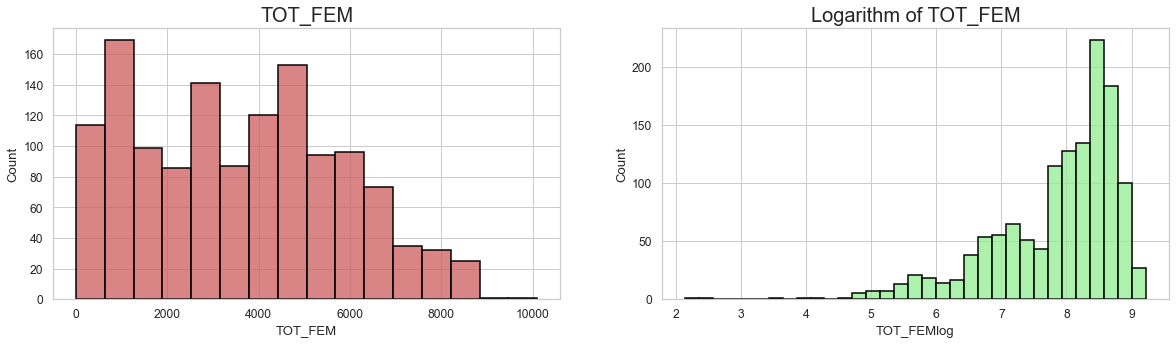

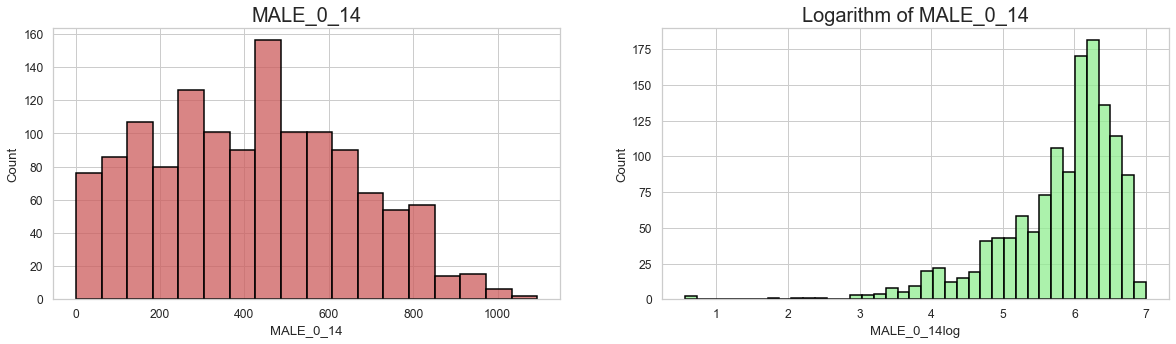

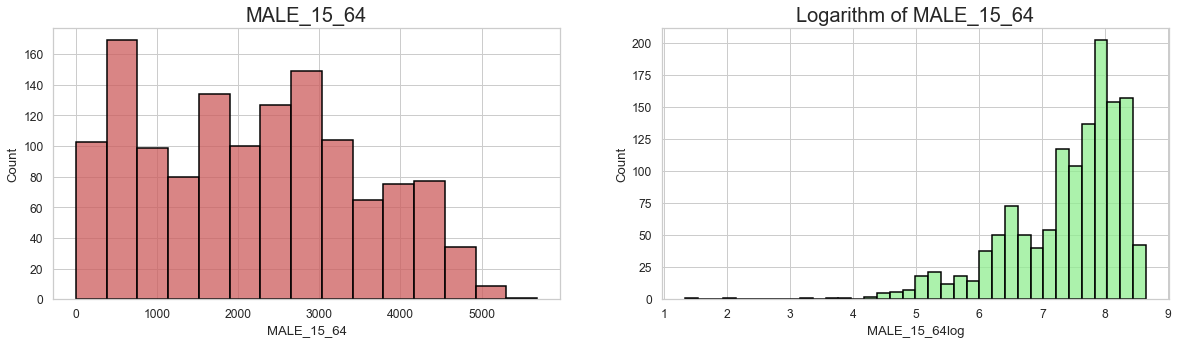

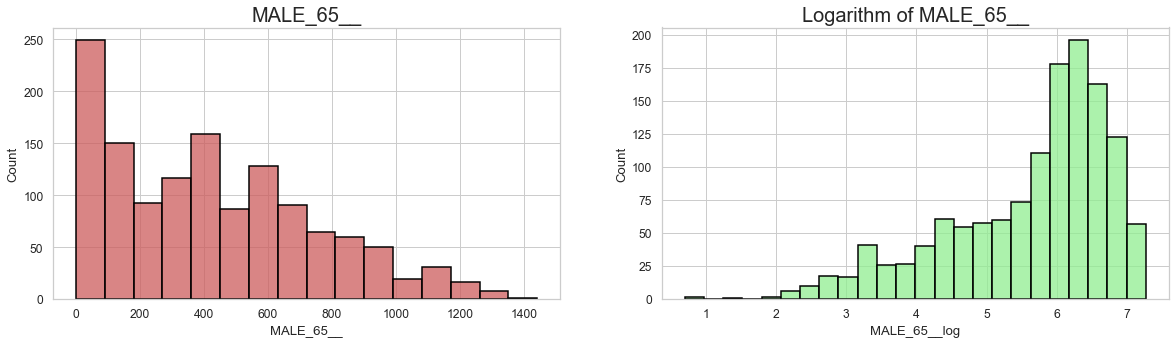

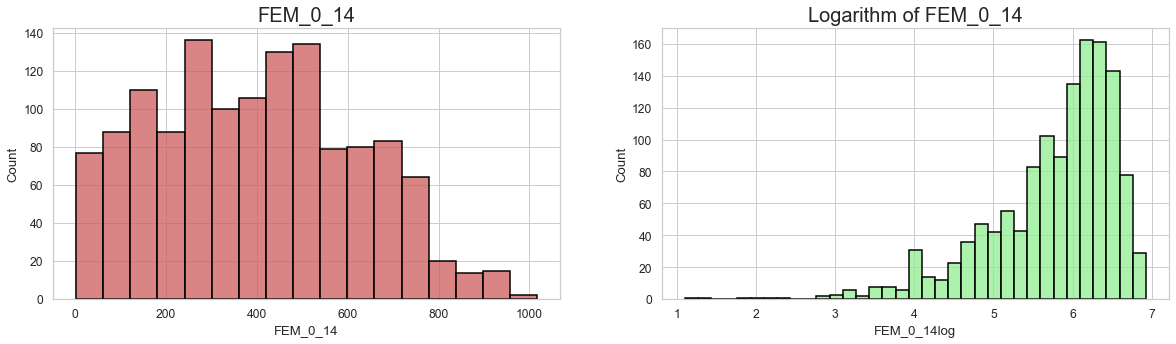

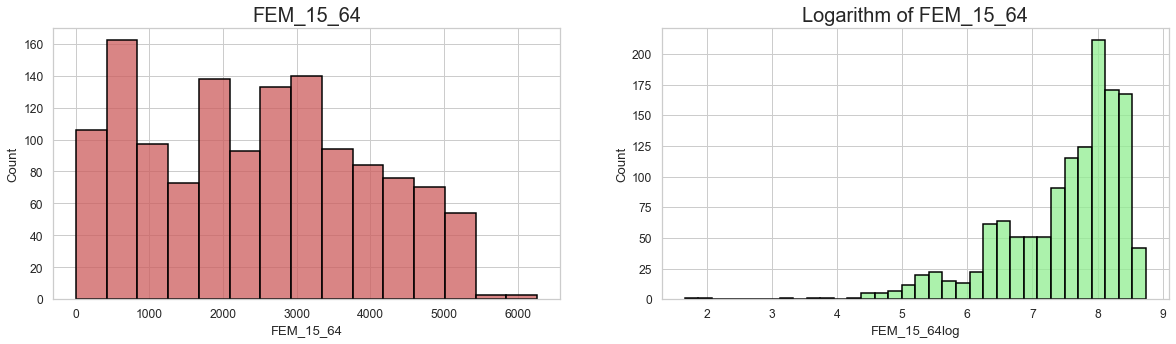

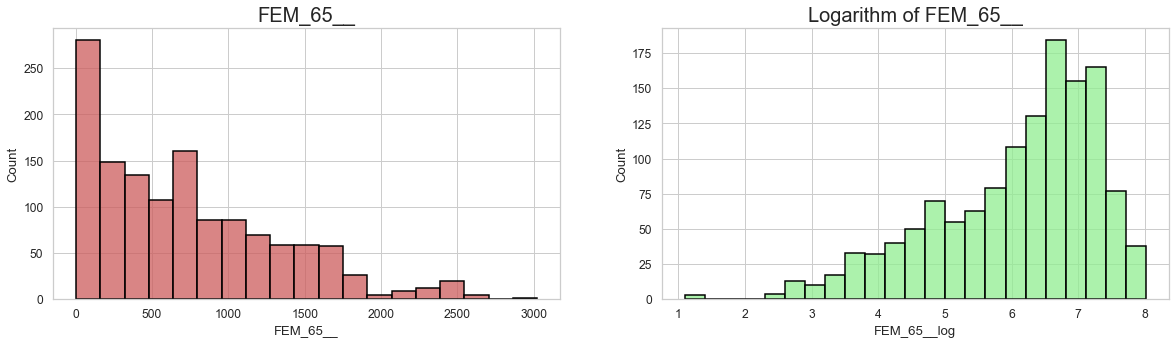

In [24]:
for point in points:
    visualisation_binary(df_gwr, point)
for point in demo_logarithms_gwr:
    visualisation_log(df_gwr, point)

In [29]:
df_gwr['geometry'] = df_gwr.apply(lambda x: shapely.wkt.loads(x['center']), axis=1)
df_gwr = gpd.GeoDataFrame(df_gwr, geometry = 'geometry', crs = "epsg:4258")
# df_gwr.to_file("../datasets/preprocessed_data/df_gwr_after_transform.shp")

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """
